In [18]:
## Standard libraries
import os

from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
from gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()


import math
import numpy as np
from typing import Any

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import seaborn as sns


## tqdm for progress bars
from tqdm import tqdm

## JAX
import jax
import jax.numpy as jnp
from jax import random
# Seeding for random operations
main_rng = random.PRNGKey(42)

from flax import linen as nn
from flax.training import train_state, checkpoints
import optax

## PyTorch Data Loading
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
# Torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/tutorial12_jax"

print("Device:", jax.devices()[0])

Device: cuda:0


/tmp/ipykernel_17440/2427251715.py:22: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 640x480 with 0 Axes>

In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/tutorial12/"
# Files to download
pretrained_files = ["PixelCNN.ckpt"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)


In [3]:
# Transformations applied on each image => bring them into a numpy array
# Note that we keep them in the range 0-255 (integers)
def image_to_numpy(img):
    img = np.array(img, dtype=np.int32)
    img = img[..., None]  # Make image [28, 28, 1]
    return img

# We need to stack the batch elements
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True,
                      transform=image_to_numpy, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000],
                                                   generator=torch.Generator().manual_seed(42))
# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False,
                 transform=image_to_numpy, download=True)

# We define a set of data loaders that we can use for various purposes
train_loader = data.DataLoader(train_set,
                               batch_size=128,
                               shuffle=True,
                               drop_last=True,
                               collate_fn=numpy_collate,
                               num_workers=8,
                               persistent_workers=True)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False,
                             drop_last=False, num_workers=4, collate_fn=numpy_collate)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False,
                              drop_last=False, num_workers=4, collate_fn=numpy_collate)

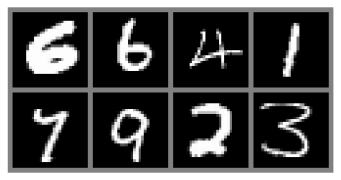

In [4]:
def show_imgs(imgs):
    imgs = jax.device_get(imgs)
    if isinstance(imgs, (list, tuple)):
        imgs = np.stack(imgs, axis=0)
    num_imgs = imgs.shape[0]
    if num_imgs < 4 or num_imgs % 4 == 0:
        nrow = min(num_imgs, 4)
        ncol = int(math.ceil(num_imgs/nrow))
    else:
        nrow = num_imgs
        ncol = 1
    imgs = np.pad(imgs, pad_width=[(0,0), (1,1), (1,1), (0,0)], constant_values=128)
    imgs = np.reshape(imgs, (nrow, ncol, *imgs.shape[1:]))
    imgs = np.transpose(imgs, (1, 2, 0, 3, 4))
    imgs = np.reshape(imgs, (imgs.shape[0]*imgs.shape[1], imgs.shape[2]*imgs.shape[3], -1))
    imgs = np.pad(imgs, pad_width=[(1,1), (1,1), (0,0)], constant_values=128)
    imgs = np.squeeze(imgs, axis=-1)
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(imgs, interpolation='nearest', cmap='gray')
    plt.axis('off')
    plt.show()
    plt.close()

show_imgs([train_set[i][0] for i in range(8)])

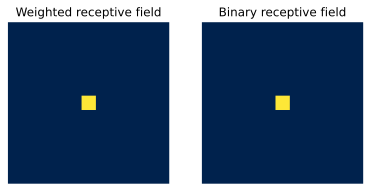

In [5]:
class MaskedConvolution(nn.Module):
    c_out : int
    mask : np.ndarray
    dilation : int = 1

    @nn.compact
    def __call__(self, x):
        # Flax's convolution module already supports masking
        # The mask must be the same size as kernel
        # => extend over input and output feature channels
        if len(self.mask.shape) == 2:
            mask_ext = self.mask[...,None,None]
            mask_ext = jnp.tile(mask_ext, (1, 1, x.shape[-1], self.c_out))
        else:
            mask_ext = self.mask
        # Convolution with masking
        x = nn.Conv(features=self.c_out,
                    kernel_size=self.mask.shape[:2],
                    kernel_dilation=self.dilation,
                    mask=mask_ext)(x)
        return x
    

class VerticalStackConvolution(nn.Module):
    c_out : int
    kernel_size : int
    mask_center : bool = False
    dilation : int = 1

    def setup(self):
        # Mask out all pixels below. For efficiency, we could also reduce the kernel
        # size in height, but for simplicity, we stick with masking here.
        mask = np.ones((self.kernel_size, self.kernel_size), dtype=np.float32)
        mask[self.kernel_size//2+1:,:] = 0
        # For the very first convolution, we will also mask the center row
        if self.mask_center:
            mask[self.kernel_size//2,:] = 0
        # Our convolution module
        self.conv = MaskedConvolution(c_out=self.c_out,
                                      mask=mask,
                                      dilation=self.dilation)

    def __call__(self, x):
        return self.conv(x)


class HorizontalStackConvolution(nn.Module):
    c_out : int
    kernel_size : int
    mask_center : bool = False
    dilation : int = 1

    def setup(self):
        # Mask out all pixels on the left. Note that our kernel has a size of 1
        # in height because we only look at the pixel in the same row.
        mask = np.ones((1, self.kernel_size), dtype=np.float32)
        mask[0,self.kernel_size//2+1:] = 0
        # For the very first convolution, we will also mask the center pixel
        if self.mask_center:
            mask[0,self.kernel_size//2] = 0
        # Our convolution module
        self.conv = MaskedConvolution(c_out=self.c_out,
                                      mask=mask,
                                      dilation=self.dilation)

    def __call__(self, x):
        return self.conv(x)


inp_img = np.zeros((1, 11, 11, 1), dtype=np.float32)

def show_center_recep_field(img, apply_fn):
    """
    Calculates the gradients of the input with respect to the output center pixel,
    and visualizes the overall receptive field.
    Inputs:
        img - Input image for which we want to calculate the receptive field on.
        out - Output features/loss which is used for backpropagation, and should be
              the output of the network/computation graph.
    """
    # Determine gradients
    grad_fn = jax.grad(lambda inp: apply_fn(inp)[0,inp.shape[1]//2,inp.shape[2]//2].sum()) # L1 loss for simplicity
    img_grads = jnp.abs(grad_fn(img))
    img_grads = jax.device_get(img_grads)

    # Plot receptive field
    img = img_grads[0,...,0]
    fig, ax = plt.subplots(1,2)
    pos = ax[0].imshow(img)
    ax[1].imshow(img>0)
    # Mark the center pixel in red if it doesn't have any gradients (should be the case for standard autoregressive models)
    show_center = (img[img.shape[0]//2,img.shape[1]//2] == 0)
    if show_center:
        center_pixel = np.zeros(img.shape + (4,))
        center_pixel[center_pixel.shape[0]//2,center_pixel.shape[1]//2,:] = np.array([1.0, 0.0, 0.0, 1.0])
    for i in range(2):
        ax[i].axis('off')
        if show_center:
            ax[i].imshow(center_pixel)
    ax[0].set_title("Weighted receptive field")
    ax[1].set_title("Binary receptive field")
    plt.show()
    plt.close()

show_center_recep_field(inp_img, lambda x: x)




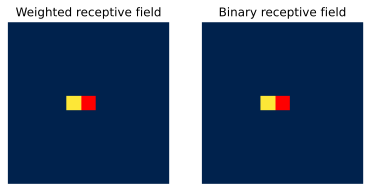

In [6]:
horiz_conv = HorizontalStackConvolution(c_out=1, kernel_size=3, mask_center=True)
# Create parameters with kernel filled with 1, and bias filled with zeros.
# As alternative, one could overwrite kernel init of
init_params = lambda params: jax.tree_map(lambda x: jnp.full(x.shape, (0 if len(x.shape) == 1 else 1), dtype=x.dtype), params)
horiz_params = horiz_conv.init(random.PRNGKey(0), inp_img)
horiz_params = init_params(horiz_params)
# Apply horizontal convolution
horiz_conv = horiz_conv.bind(horiz_params)
show_center_recep_field(inp_img, lambda inp: horiz_conv(inp))

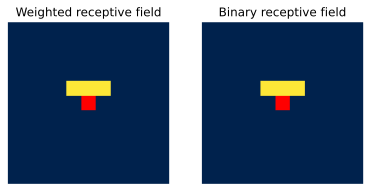

In [18]:
vert_conv = VerticalStackConvolution(c_out=1, kernel_size=3, mask_center=True)
vert_params = vert_conv.init(random.PRNGKey(0), inp_img)
vert_params = init_params(vert_params)
vert_conv = vert_conv.bind(vert_params)
show_center_recep_field(inp_img, lambda inp: vert_conv(inp))



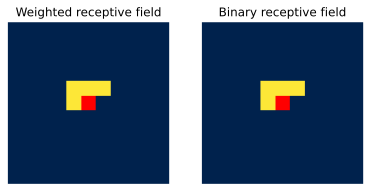

In [19]:
show_center_recep_field(inp_img, lambda inp: vert_conv(inp) + horiz_conv(inp))

Layer 2


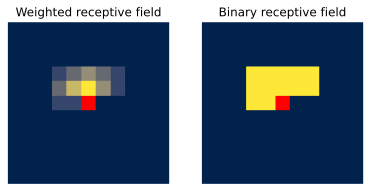

Layer 3


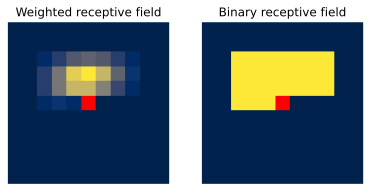

Layer 4


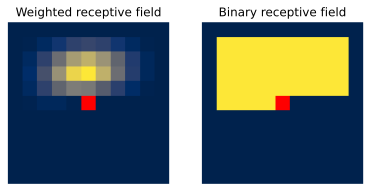

Layer 5


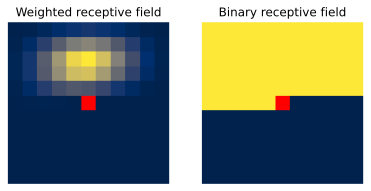

In [20]:
# Convolutions with mask_center=False, no need for new parameters since
horiz_noc_conv = HorizontalStackConvolution(c_out=1, kernel_size=3, mask_center=False)
vert_noc_conv = VerticalStackConvolution(c_out=1, kernel_size=3, mask_center=False)
horiz_noc_conv = horiz_noc_conv.bind(horiz_params)
vert_noc_conv = vert_noc_conv.bind(vert_params)

# We reuse our convolutions for the several layers with same parameters just for visualization.
def num_layer_network(inp, num_layers):
    vert_img = vert_conv(inp)
    horiz_img = horiz_conv(inp) + vert_img
    for _ in range(num_layers-1):
        vert_img = vert_noc_conv(vert_img)
        horiz_img = horiz_noc_conv(horiz_img) + vert_img
    return horiz_img, vert_img

for layer_count in range(2, 6):
    print(f"Layer {layer_count}")
    show_center_recep_field(inp_img, lambda inp: num_layer_network(inp, layer_count)[0])


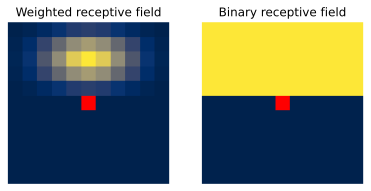

In [10]:
show_center_recep_field(inp_img, lambda inp: num_layer_network(inp, 5)[1])

In [7]:
class GatedMaskedConv(nn.Module):
    dilation : int = 1

    @nn.compact
    def __call__(self, v_stack, h_stack):
        c_in = v_stack.shape[-1]

        # Layers (depend on input shape)
        conv_vert = VerticalStackConvolution(c_out=2*c_in,
                                             kernel_size=3,
                                             mask_center=False,
                                             dilation=self.dilation)
        conv_horiz = HorizontalStackConvolution(c_out=2*c_in,
                                                kernel_size=3,
                                                mask_center=False,
                                                dilation=self.dilation)
        conv_vert_to_horiz = nn.Conv(2*c_in,
                                     kernel_size=(1, 1))
        conv_horiz_1x1 = nn.Conv(c_in,
                                 kernel_size=(1, 1))

        # Vertical stack (left)
        v_stack_feat = conv_vert(v_stack)
        v_val, v_gate = jnp.split(v_stack_feat, 2, axis=-1)
        v_stack_out = nn.tanh(v_val) * nn.sigmoid(v_gate)

        # Horizontal stack (right)
        h_stack_feat = conv_horiz(h_stack)
        h_stack_feat = h_stack_feat + conv_vert_to_horiz(v_stack_feat)
        h_val, h_gate = jnp.split(h_stack_feat, 2, axis=-1)
        h_stack_feat = nn.tanh(h_val) * nn.sigmoid(h_gate)
        h_stack_out = conv_horiz_1x1(h_stack_feat)
        h_stack_out = h_stack_out + h_stack

        return v_stack_out, h_stack_out

In [8]:
class PixelCNN(nn.Module):
    c_in : int
    c_hidden : int

    def setup(self):
        # Initial convolutions skipping the center pixel
        self.conv_vstack = VerticalStackConvolution(self.c_hidden, kernel_size=3, mask_center=True)
        self.conv_hstack = HorizontalStackConvolution(self.c_hidden, kernel_size=3, mask_center=True)
        # Convolution block of PixelCNN. We use dilation instead of downscaling
        self.conv_layers = [
            GatedMaskedConv(),
            GatedMaskedConv(dilation=2),
            GatedMaskedConv(),
            GatedMaskedConv(dilation=4),
            GatedMaskedConv(),
            GatedMaskedConv(dilation=2),
            GatedMaskedConv()
        ]
        # Output classification convolution (1x1)
        self.conv_out = nn.Conv(self.c_in * 256, kernel_size=(1, 1))

    def __call__(self, x):
        # Forward pass with bpd likelihood calculation
        logits = self.pred_logits(x)
        labels = x.astype(jnp.int32)
        nll = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
        bpd = nll.mean() * np.log2(np.exp(1))
        return bpd

    def pred_logits(self, x):
        """
        Forward image through model and return logits for each pixel.
        Inputs:
            x - Image tensor with integer values between 0 and 255.
        """
        # Scale input from 0 to 255 back to -1 to 1
        x = (x.astype(jnp.float32) / 255.0) * 2 - 1

        # Initial convolutions
        v_stack = self.conv_vstack(x)
        h_stack = self.conv_hstack(x)
        # Gated Convolutions
        for layer in self.conv_layers:
            v_stack, h_stack = layer(v_stack, h_stack)
        # 1x1 classification convolution
        # Apply ELU before 1x1 convolution for non-linearity on residual connection
        out = self.conv_out(nn.elu(h_stack))

        # Output dimensions: [Batch, Height, Width, Channels, Classes]
        out = out.reshape(out.shape[0], out.shape[1], out.shape[2], out.shape[3]//256, 256)
        return out

    def sample(self, img_shape, rng, img=None):
        """
        Sampling function for the autoregressive model.
        Inputs:
            img_shape - Shape of the image to generate (B,C,H,W)
            img (optional) - If given, this tensor will be used as
                             a starting image. The pixels to fill
                             should be -1 in the input tensor.
        """
        # Create empty image
        if img is None:
            img = jnp.zeros(img_shape, dtype=jnp.int32) - 1
        # We jit a prediction step. One could jit the whole loop, but this
        # is expensive to compile and only worth for a lot of sampling calls.
        # get_logits = jax.jit(lambda inp: self.pred_logits(inp))
        get_logits = lambda inp: self.pred_logits(inp)
 
        # Generation loop
        for h in tqdm(range(img_shape[1]), leave=False):
            for w in range(img_shape[2]):
                for c in range(img_shape[3]):
                    # Skip if not to be filled (-1)
                    if (img[:,h,w,c] != -1).all().item():
                        continue
                    # For efficiency, we only have to input the upper part of the image
                    # as all other parts will be skipped by the masked convolutions anyways
                    logits = get_logits(img)
                    logits = logits[:,h,w,c,:]
                    rng, pix_rng = random.split(rng)
                    img = img.at[:,h,w,c].set(random.categorical(pix_rng, logits, axis=-1))
        return img

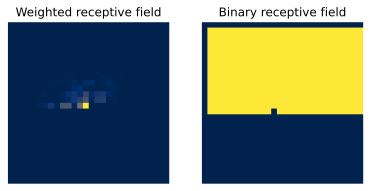

In [9]:
model = PixelCNN(c_in=1, c_hidden=64)
# inp = random.randint(random.PRNGKey(1), (1,28,28,1), 0, 255).astype(jnp.float32)
inp = jnp.zeros((1,28,28,1))
params = model.init(random.PRNGKey(0), inp)
show_center_recep_field(inp, lambda x: model.bind(params).pred_logits(x)[...,0,0])



In [13]:
grads = jax.grad(lambda p: model.apply(p, inp))(params)
# Gradients of the weights in the first h-stack convolution
# for the first feature map:
grads['params']['conv_hstack']['conv']['Conv_0']['kernel'][:,:,:,0]



Array([[[0.10627804],
        [0.        ],
        [0.        ]]], dtype=float32)

In [10]:
class TrainerModule:

    def __init__(self,
                 c_in : int,
                 c_hidden : int,
                 exmp_imgs : Any,
                 lr : float = 1e-3,
                 seed : int = 42):
        """
        Module for summarizing all training functionalities for the PixelCNN.
        """
        super().__init__()
        self.lr = lr
        self.seed = seed
        self.model_name = 'PixelCNN'
        # Create empty model. Note: no parameters yet
        self.model = PixelCNN(c_in=c_in, c_hidden=c_hidden)
        # Prepare logging
        self.log_dir = os.path.join(CHECKPOINT_PATH, self.model_name)
        self.logger = SummaryWriter(log_dir=self.log_dir)
        # Create jitted training and eval functions
        self.create_functions()
        # Initialize model
        self.init_model(exmp_imgs)

    def create_functions(self):
        # Training function
        def train_step(state, batch):
            imgs, _ = batch
            loss_fn = lambda params: state.apply_fn(params, imgs)
            loss, grads = jax.value_and_grad(loss_fn)(state.params)
            state = state.apply_gradients(grads=grads)
            return state, loss
        # Eval function
        def eval_step(state, batch):
            imgs, _ = batch
            loss = state.apply_fn(state.params, imgs)
            return loss
        # jit for efficiency
        self.train_step = jax.jit(train_step)
        self.eval_step = jax.jit(eval_step)

    def init_model(self, exmp_imgs):
        # Initialize model
        init_rng = random.PRNGKey(self.seed)
        params = self.model.init(init_rng, exmp_imgs)
        self.state = train_state.TrainState(step=0,
                                            apply_fn=self.model.apply,
                                            params=params,
                                            tx=None,
                                            opt_state=None)

    def init_optimizer(self, num_epochs, num_steps_per_epoch):
        # Initialize learning rate schedule and optimizer
        lr_schedule = optax.exponential_decay(
            init_value=self.lr,
            transition_steps=num_steps_per_epoch,
            decay_rate=0.99
        )
        optimizer = optax.adam(lr_schedule)
        # Initialize training state
        self.state = train_state.TrainState.create(apply_fn=self.state.apply_fn,
                                                   params=self.state.params,
                                                   tx=optimizer)

    def train_model(self, train_loader, val_loader, num_epochs=200):
        # Train model for defined number of epochs
        # We first need to create optimizer and the scheduler for the given number of epochs
        self.init_optimizer(num_epochs, len(train_loader))
        # Track best eval bpd score.
        best_eval = 1e6
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(train_loader, epoch=epoch_idx)
            if epoch_idx % 1 == 0:
                eval_bpd = self.eval_model(val_loader)
                self.logger.add_scalar('val/bpd', eval_bpd, global_step=epoch_idx)
                if eval_bpd <= best_eval:
                    best_eval = eval_bpd
                    self.save_model(step=epoch_idx)
            self.logger.flush()

    def train_epoch(self, train_loader, epoch):
        # Train model for one epoch, and log avg bpd
        avg_loss = 0
        for batch in tqdm(train_loader, desc='Training', leave=False):
            self.state, loss = self.train_step(self.state, batch)
            avg_loss += loss
        avg_loss /= len(train_loader)
        self.logger.add_scalar('train/bpd', avg_loss.item(), global_step=epoch)

    def eval_model(self, data_loader):
        # Test model on all images of a data loader and return avg bpd
        avg_bpd, count = 0, 0
        for batch in data_loader:
            bpd = self.eval_step(self.state, batch)
            avg_bpd += bpd * batch[0].shape[0]
            count += batch[0].shape[0]
        eval_bpd = (avg_bpd / count).item()
        return eval_bpd

    def save_model(self, step=0):
        # Save current model at certain training iteration
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir,
                                    target=self.state.params,
                                    step=step,
                                    overwrite=True)

    def load_model(self, pretrained=False):
        # Load model. We use different checkpoint for pretrained models
        if not pretrained:
            state_dict = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=None)
        else:
            state_dict = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'), target=None)
        self.state = train_state.TrainState.create(apply_fn=self.state.apply_fn,
                                                   params=state_dict,
                                                   tx=self.state.tx if self.state.tx else optax.sgd(0.1)   # Default optimizer
                                                  )

    def checkpoint_exists(self):
        # Check whether a pretrained model exist for this autoencoder
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'))



In [15]:
def train_model(max_epochs=150, load_existing=False, **model_args):
    # Create a trainer module with specified hyperparameters
    trainer = TrainerModule(exmp_imgs=next(iter(train_loader))[0],
                            **model_args)
    # if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
    trainer.train_model(train_loader, val_loader, num_epochs=max_epochs)
    trainer.load_model()
    # else:
    #     trainer.load_model(pretrained=True)
    val_bpd = trainer.eval_model(val_loader)
    test_bpd = trainer.eval_model(test_loader)
    # Bind parameters to model for easier inference
    trainer.model_bd = trainer.model.bind(trainer.state.params)
    return trainer, {'val_bpd': val_bpd, 'test_bpd': test_bpd}



In [20]:
trainer, result = train_model(max_epochs=150, load_existing=False, c_in=1, c_hidden=64)
print(f'Test bpd: {result["test_bpd"]:4.3f}')

  0%|          | 0/150 [02:59<?, ?it/s]


KeyboardInterrupt: 

In [31]:
num_params = sum([np.prod(p.shape) for p in jax.tree_leaves(trainer.state.params)])
print("Number of parameters: {:,}".format(num_params))

Number of parameters: 852,160


/tmp/ipykernel_18819/2574050472.py:1: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree_util.tree_leaves.
  num_params = sum([np.prod(p.shape) for p in jax.tree_leaves(trainer.state.params)])


  0%|          | 0/28 [00:00<?, ?it/s]

/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


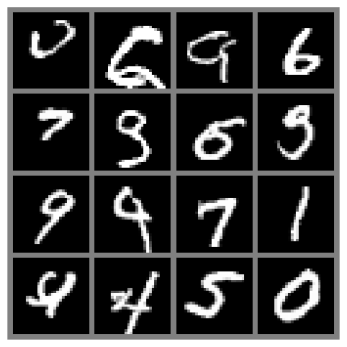

: 

In [25]:
samples = trainer.model_bd.sample(img_shape=(16,28,28,1), rng=random.PRNGKey(0))
show_imgs(samples)